# PilotNet training

## Import modules

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image

## [TODO] Designate path to datasets

## Define Preprocessing Pipeline

In [2]:
import tensorflow as tf

# Keras implemented with TF backend
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [3]:
# define custom scikit-learn estimator & transformer performing MinMaxScaling on each channels
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import shuffle

class ImageMinMaxScaler(BaseEstimator, TransformerMixin):

  def __init__(self):
    return

  def fit(self, X=None, y=None):
    return self
    
  def transform(self, X, y=None):
    # scale every pixel value to fit in [0, 1]
    result = X / 255

    return result

  def fit_transform(self, X, y=None):
    self.fit()

    result = self.transform(X)
    return result

In [4]:
# define custom scikit-learn estimator & transformer resizing given image
from sklearn.base import BaseEstimator, TransformerMixin

class ImageResizer(TransformerMixin):

  def __init__(self, target_size=(200, 66)):
      self.target_size = target_size
      return

  def fit(self, X=None, y=None):
      return self

  def transform(self, X):
      result = cv2.resize(X, self.target_size, interpolation=cv2.INTER_AREA)
      return np.swapaxes(result, axis1=0, axis2=1)

  def fit_transform(self, X, y=None):
      return self.transform(X)

In [5]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([                     
                     ('ImageMinMaxScaler', ImageMinMaxScaler()), # scales the pixel values to range [0, 1]
                     ('ImageResizer', ImageResizer())  # resizes given image to match the input layer size of the NN

])

In [19]:
## Check CSV file

merged_dataset = pd.read_csv('./dataset-drive/datasets_mod.csv')

merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70991 entries, 0 to 70990
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      70991 non-null  int64 
 1   Unnamed: 0.1    70991 non-null  int64 
 2   Unnamed: 0.1.1  70991 non-null  int64 
 3   drive_view      70991 non-null  object
 4   control         70991 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


## Define Custom dataloader

In [6]:
import os
import pathlib
import math

from tensorflow.keras.utils import Sequence

class Dataloader(Sequence):
    
  def __init__(self, dataset_dir, batch_size=32, shuffle=False):
    # initialize basic member variables
    self.dataset_dir = pathlib.Path(dataset_dir)
    self.shuffle= shuffle
    self.batch_size = batch_size
    
    # make list of files
    self.file_names = []
    for root, dirs, files in os.walk(self.dataset_dir):
        for file in files:
            if file.endswith('.jpg'):
                self.file_names.append(file)
    
    self.num_img = len(self.file_names)
    
    # set directory storing images
    self.x_path = "./" + str(self.dataset_dir) + "/imgs"
    
    # read labels from CSV file in the directory
    csv_path = str(self.dataset_dir) + "/" + "dataset.csv"
    df_temp = pd.read_csv(csv_path)
    self.y = df_temp['control'].to_numpy()
    
    # initialize indices once
    self.on_epoch_end()
    
  def __len__(self):
    return math.ceil(self.num_img / self.batch_size)

  def __getitem__(self, idx):
        
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        # empty batch
        batch_x = []
        batch_y = []
        
        # generate batch 
        for i in batch_indices:
            img_path = self.x_path + "/" + self.file_names[i]
            img = load_img(img_path, color_mode='rgb', target_size=(66, 200))
            img_arr = img_to_array(img) / 255 
            img_arr = np.swapaxes(img_arr, 1, 0)
            batch_x.append(img_arr)
            batch_y.append(self.y[i])
        
        return np.array(batch_x), np.array(batch_y)
    
  def on_epoch_end(self):
    self.indices = np.arange(self.num_img)
    if self.shuffle == True:
        np.random.shuffle(self.indices)
        

In [37]:
class Dataloader_from_CSV(Sequence):

    def __init__(self, csv_path, batch_size=32, shuffle=False):
        # initialize basic member variables
        self.csv_path = pathlib.Path(csv_path)
        self.shuffle= shuffle
        self.batch_size = batch_size
    
        self.df = pd.read_csv(csv_path)

        self.X_source_dir = self.df['drive_view']
        self.y = self.df['control'].to_numpy()
    
        self.num_samples = len(self.df)
    
        # initialize indices once
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size)

    def __getitem__(self, idx):
        
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        # empty batch
        batch_x = []
        batch_y = []
        
        # generate batch 
        for i in batch_indices:
            img_path = self.X_source_dir.iloc[i]

            dirs = img_path.split('/')
            dirs[1] = 'dataset-drive'
            img_path = '/'.join(dirs)

            img = load_img(img_path, color_mode='rgb', target_size=(66, 200))
            img_arr = img_to_array(img) / 255 
            img_arr = np.swapaxes(img_arr, 1, 0)
            batch_x.append(img_arr)
            batch_y.append(self.y[i])
        
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        self.indices = np.arange(self.num_samples)
        if self.shuffle == True:
            np.random.shuffle(self.indices)

## Testing Default Dataloader (load data from each directory)

In [35]:
test_path = "./dataset-drive/210119_12-14-48_data"

test_loader = Dataloader(test_path)
print(test_loader.y, test_loader.y.shape, test_loader.num_img)

batch_x, batch_y = test_loader[0]   # test: get 0th batch

['S' 'S' 'W' ... 'W' nan nan] (10780,) 7151


In [31]:
%matplotlib inline

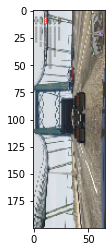

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplt = plt.imshow(batch_x[0])

## Testing CSV compatible Dataloader

In [38]:
csv_path = './dataset-drive/datasets_mod.csv'

test_loader = Dataloader_from_CSV(csv_path)

batch_x, batch_y = test_loader[0]

FileNotFoundError: [Errno 2] No such file or directory: './dataset-drive/210119_12-14-48_data/imgs/drive_view0.jpg'

In [10]:
def img_to_arr(p):
    with image.load_img(p) as img:
        img = image.img_to_array(img)
    return img

In [11]:
target_dataset = "/content/drive/MyDrive/AutopilotDrive/dataset/"
df = pd.read_csv(target_dataset + "/datasets_mod.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AutopilotDrive/dataset//datasets_mod.csv'

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array # Image Related

random_indices = np.random.randint(low=0, high=len(df), size=100)

X_train = np.array([img_to_arr(target_dataset + "../" + image_name) for image_name in df['drive_view'].iloc[random_indices]])

In [ ]:
from sklearn.preprocessing import StandardScaler

for i in range(len(random_indices)):
    scaler_R = StandardScaler().fit(X_train[i][:,:,0])
    scaler_G = StandardScaler().fit(X_train[i][:,:,1])
    scaler_B = StandardScaler().fit(X_train[i][:,:,2])

def normalize(img):
    img[:,:,0] = scaler_R.transform(img[:,:,0])
    img[:,:,1] = scaler_G.transform(img[:,:,1])
    img[:,:,2] = scaler_B.transform(img[:,:,2])
    return img

In [ ]:
# define generator that loops through the data
def generator(df, batch_size, img_shape, should_shuffle):
    # shuffle dataframe for each epoch
    if should_shuffle:
        df = shuffle(df)
        
    img_list = df['drive_view']
    steer = df['control']
    
    # create empty batch
    batch_img = np.zeros((batch_size,) + img_shape)
    batch_label = np.zeros((batch_size, 1))
    
    index = 0
    while True:
        for i in range(batch_size):
            img_name = img_list[index]
            arr = img_to_arr(target_dataset + "../" + img_name)
            
            batch_img[i] = normalize(arr, scaler_R, scaler_G, scaler_B)
            batch_label[i] = steer[index]
            
            index += 1
            if index == len(img_list):
                index = 0
            
        yield batch_img, batch_label

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,drive_view,control
0,0,0,1,./dataset/210119_12-14-48_data/imgs/drive_view...,3
1,1,1,2,./dataset/210119_12-14-48_data/imgs/drive_view...,3
2,2,2,3,./dataset/210119_12-14-48_data/imgs/drive_view...,1
3,3,3,4,./dataset/210119_12-14-48_data/imgs/drive_view...,1
4,4,4,5,./dataset/210119_12-14-48_data/imgs/drive_view...,1


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size = 0.2)

In [ ]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,drive_view,control
17391,19245,8465,19246,./dataset/210119_12-16-36_data/imgs/drive_view...,0
17524,19378,8598,19379,./dataset/210119_12-16-36_data/imgs/drive_view...,1
64483,72823,2562,72824,./dataset/210126_07-25-00_data/imgs/drive_view...,1
1974,2157,2157,2158,./dataset/210119_12-14-48_data/imgs/drive_view...,1
26831,28685,562,28686,./dataset/210119_12-24-51_data/imgs/drive_view...,0


In [ ]:
df_train['drive_view'].iloc[0]

'./dataset/210119_12-16-36_data/imgs/drive_view8465.jpg'

In [ ]:
sample_image = img_to_arr(target_dataset + "../" + df_train['drive_view'].iloc[0])
input_shape = sample_image.shape
batch_size = 32
train_steps = (df_train.shape[0] / batch_size) + 1
val_steps = (df_valid.shape[0] / batch_size) + 1

print("input_shape: %s, batch_size: %d, train_steps: %d, val_steps: %d" % 
      (input_shape, batch_size, train_steps, val_steps))

input_shape: (256, 455, 3), batch_size: 32, train_steps: 1775, val_steps: 444


In [ ]:
train_batch = generator(df_train, batch_size, input_shape, True)
val_batch = generator(df_valid, batch_size, input_shape, False)

# Define Sequential Model

In [ ]:
drop_out_rate = 0.2

model = models.Sequential()
# model.add(Rescaling(scale=1./255))

# three Conv2D layers with 5 x 5 kernels, and 2 x 2 strides
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),
                              padding='valid', activation='relu', input_shape=(200, 66, 3)))
model.add(Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2),
                              padding='valid', activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2),
                              padding='valid', activation='relu'))

# two Conv2D layers with 3 x 3 kernels, and no strides
model.add(Conv2D(filters=64, kernel_size=(3, 3),
                              padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3),
                              padding='valid', activation='relu'))

# and data flows to three fully-connected layers
model.add(Flatten())   # (None, 1152)
model.add(Dense(units=1152))
model.add(Dropout(rate=drop_out_rate))
model.add(Dense(units=100))
model.add(Dropout(rate=drop_out_rate))
model.add(Dense(units=50))
model.add(Dropout(rate=drop_out_rate))
model.add(Dense(units=10))
model.add(Dropout(rate=drop_out_rate))
model.add(Dense(units=5, activation='softmax'))

# build the pilotNet model
model.build(input_shape=(None, 200, 66, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 31, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 14, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 3, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 1152)              1

In [ ]:
model.compile(optimizer='adam',
                loss='cross_entropy',
                metrics=['f1_score'])

In [ ]:
model_path = target_dataset + "/model"
# define callbacks
cur_model = 'PilotNet_v1'
csv_logger = CSVLogger(os.path.join("./", cur_model + '.log'))

model_file_name= os.path.join(model_path, cur_model + '-{epoch:03d}-{val_loss:.5f}.h5')
checkpoint = ModelCheckpoint(model_file_name, verbose=0, save_best_only=True)

In [ ]:
print(type(train_batch))

<class 'generator'>


In [ ]:
model.fit_generator(train_batch, train_steps, epochs=20, verbose=1, 
                    callbacks=[csv_logger, checkpoint], 
                    validation_data=val_batch, 
                    validation_steps=val_steps)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


StopIteration: ignored

## Training Model